In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names-shuffled.txt', 'r').read().splitlines()

In [5]:
words[:8]

['pushp',
 'aishwary',
 'prahalan',
 'adrija',
 'ghanika',
 'vibulan',
 'kavinthran',
 'priyaalen']

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k, v in stoi.items()}

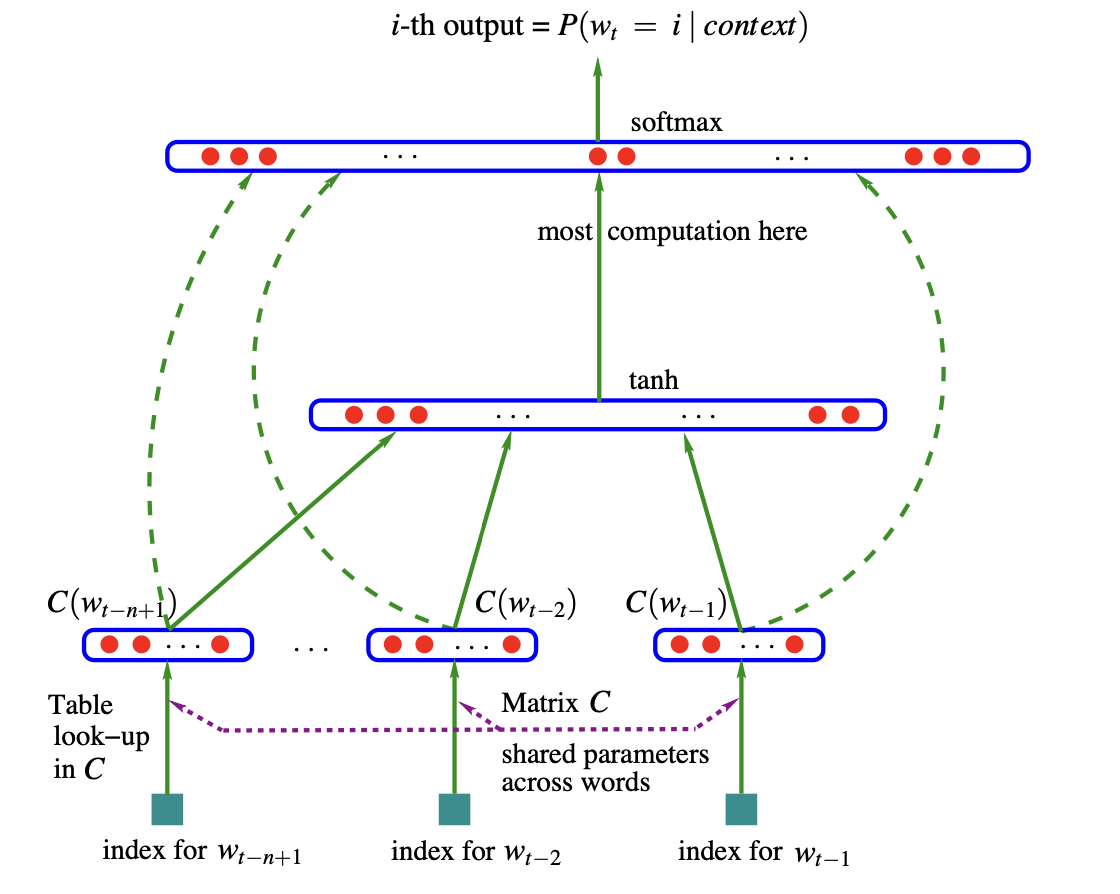

In [7]:
# build the dataset

block_size = 3 # context length: number of chars used to predict the next char
X, Y = [], [] # inputs and labels

for w in words[:3]:
    print(w)
    context = [0] * block_size
    for c in w + '.':
        
        print(f"{''.join(itos[item] for item in context)} --> {c}")

        X.append(context)
        Y.append(stoi[c])
        context = context[1:] + [stoi[c]] # sliding the context by 1 character to right
    print('-----------')

X = torch.tensor(X)
Y = torch.tensor(Y)

pushp
... --> p
..p --> u
.pu --> s
pus --> h
ush --> p
shp --> .
-----------
aishwary
... --> a
..a --> i
.ai --> s
ais --> h
ish --> w
shw --> a
hwa --> r
war --> y
ary --> .
-----------
prahalan
... --> p
..p --> r
.pr --> a
pra --> h
rah --> a
aha --> l
hal --> a
ala --> n
lan --> .
-----------


In [8]:
X.shape, Y.shape

(torch.Size([24, 3]), torch.Size([24]))

In [9]:
g = torch.Generator().manual_seed(1337101)

C = torch.randn((27, 2), generator=g) # lookup table

C is the lookup table which will contain the embeddings for all 27 characters. It is a matrix of size 27x2.
Meaning, it contains embedding of length 2 for a character.

How to get embedding of a character from C?

There are 2 ways:
- We can directly do C[i], where i is the integer corrosponding to a character e.g. 1 for a and 2 for b.
- We can create a one hot encodding for a character and then multiply that 1x27 one hot encoding by matrix C.

Both of these operations will result in an encoding of size 1x2 for a character because all encodings are for size 2.

In [10]:
print(C[5]) # first method
t = F.one_hot(torch.tensor(5), num_classes=27).float()
print(t@C) # second method

# both of these operations will result in same output. We'll choose the first method.

tensor([0.2890, 0.7356])
tensor([0.2890, 0.7356])


Now we want to encode the complete X tensor which is of size [m, block_size].

For explanation, let's take m=24 and block_size=3. So X is of size [24, 3].

PyTorch can do this directly by passing X to C like C[X]. This will result in an output of size [24, 3, 2].

X contains 3 characters in all the 24 rows and all the characters have and embedding of size 2. Hence the size of output
is [24, 3, 2].

In [11]:
C[X].shape

torch.Size([24, 3, 2])

In [45]:
print(X[0])
C[X][0]

# all 3 embeddings are same because all the characters are same.

tensor([0, 0, 0])


tensor([[ 0.6996, -0.1849],
        [ 0.6996, -0.1849],
        [ 0.6996, -0.1849]])

In [12]:
emb = C[X]
emb.shape

torch.Size([24, 3, 2])

In [13]:
g = torch.Generator().manual_seed(1337101)
W1 = torch.randn((3*2, 100), generator=g)
b1 = torch.randn(100, generator=g)

W1 is the weight of the hidden layer. There will be 3 inputs of size 2 (size of embedding). In this layer we've taken 100
neurons. It means each neuron has a column vector of size 3*2 which are stacked in a matrix W1 of size (3 * 2 X 100)

The emb matrix which is of size [24, 3, 2] cannot be multiplied with the W1 matrix which is of size [6, 100]. So, in order to multiply these we'll have to change the shape of emb matrix to [24, 6].

Doing so will stack all the 24 sub-matrices of size 3x2 in 24 rows. Basically a 3x2 sub-matrix will become a row vector of size 1x6 and there will be 24 such rows, hence the size would be 24x6.

In [14]:
emb

tensor([[[ 0.6996, -0.1849],
         [ 0.6996, -0.1849],
         [ 0.6996, -0.1849]],

        [[ 0.6996, -0.1849],
         [ 0.6996, -0.1849],
         [ 0.2846,  0.9114]],

        [[ 0.6996, -0.1849],
         [ 0.2846,  0.9114],
         [-1.9966,  0.9623]],

        [[ 0.2846,  0.9114],
         [-1.9966,  0.9623],
         [-0.3855, -0.1194]],

        [[-1.9966,  0.9623],
         [-0.3855, -0.1194],
         [ 0.6661, -0.9367]],

        [[-0.3855, -0.1194],
         [ 0.6661, -0.9367],
         [ 0.2846,  0.9114]],

        [[ 0.6996, -0.1849],
         [ 0.6996, -0.1849],
         [ 0.6996, -0.1849]],

        [[ 0.6996, -0.1849],
         [ 0.6996, -0.1849],
         [ 3.1742, -1.1452]],

        [[ 0.6996, -0.1849],
         [ 3.1742, -1.1452],
         [-2.0882,  1.1182]],

        [[ 3.1742, -1.1452],
         [-2.0882,  1.1182],
         [-0.3855, -0.1194]],

        [[-2.0882,  1.1182],
         [-0.3855, -0.1194],
         [ 0.6661, -0.9367]],

        [[-0.3855, -0

In [15]:
emb = emb.view(-1, 6)
emb.shape

torch.Size([24, 6])

In [16]:
emb

tensor([[ 0.6996, -0.1849,  0.6996, -0.1849,  0.6996, -0.1849],
        [ 0.6996, -0.1849,  0.6996, -0.1849,  0.2846,  0.9114],
        [ 0.6996, -0.1849,  0.2846,  0.9114, -1.9966,  0.9623],
        [ 0.2846,  0.9114, -1.9966,  0.9623, -0.3855, -0.1194],
        [-1.9966,  0.9623, -0.3855, -0.1194,  0.6661, -0.9367],
        [-0.3855, -0.1194,  0.6661, -0.9367,  0.2846,  0.9114],
        [ 0.6996, -0.1849,  0.6996, -0.1849,  0.6996, -0.1849],
        [ 0.6996, -0.1849,  0.6996, -0.1849,  3.1742, -1.1452],
        [ 0.6996, -0.1849,  3.1742, -1.1452, -2.0882,  1.1182],
        [ 3.1742, -1.1452, -2.0882,  1.1182, -0.3855, -0.1194],
        [-2.0882,  1.1182, -0.3855, -0.1194,  0.6661, -0.9367],
        [-0.3855, -0.1194,  0.6661, -0.9367, -1.5830,  0.2552],
        [ 0.6661, -0.9367, -1.5830,  0.2552,  3.1742, -1.1452],
        [-1.5830,  0.2552,  3.1742, -1.1452, -0.5481,  1.1859],
        [ 3.1742, -1.1452, -0.5481,  1.1859, -0.2676,  0.0822],
        [ 0.6996, -0.1849,  0.6996, -0.1

In [17]:
b1.shape

torch.Size([100])

In [18]:
h = torch.tanh((emb @ W1) + b1)
h.shape

torch.Size([24, 100])

X = emb @ W1

Here, X[i][j] represents the activation of jth neuron because of thev ith input.

In [19]:
g = torch.Generator().manual_seed(1337101)

W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

In [20]:
logits = (h @ W2) + b2
logits.shape

torch.Size([24, 27])

In [21]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
prob.shape

torch.Size([24, 27])

prob contains the probabilities of being the next the next character in sequence. It contains probabilities for 24 examples.

As currently we're in training phase, we want to extract and compare the probabilities of labels (the correct character in
the sequence).

For this we can use simple indexing. Since we have to do this for all 24 examples, we'll have to pluck each row one by one and
in those rows we'll have to get the value of yth character where y is the correct next character in the sequence.

In [22]:
row_index = torch.arange(24) # to iterate the rows
col_index = Y                # to get the prob of correct character which is assigned by the model

In [23]:
prob[row_index, col_index]

tensor([9.8409e-14, 1.2422e-11, 6.4264e-05, 7.1055e-05, 2.7663e-11, 2.3793e-10,
        9.0230e-11, 8.8550e-11, 3.8269e-07, 1.6356e-05, 1.2956e-07, 2.8650e-06,
        8.7959e-07, 1.6308e-13, 2.0602e-03, 9.8409e-14, 2.8677e-04, 1.0054e-04,
        2.1865e-08, 3.3273e-06, 2.3237e-13, 6.1691e-10, 1.2928e-01, 3.4215e-15])

In [24]:
nll = -prob[row_index, col_index].log().mean()
nll

tensor(18.0924)

### CE vs NLL

We can directly use cross entropy rather than calculating the NLL. Cross Entropy is similar to NLL. CE is directly applied
on the logits and applies softmax (counts/counts.sum()) internally. NLL expects log probabilities which means we've to apply
the log and softmax on the logits.

PyTorch's CE implementation is efficient in the sense of mathematical calculation and backpropagation.

In [25]:
# counts = logits.exp()
# prob = counts / counts.sum(dim=1, keepdim=True)
# nll = -prob[row_index, col_index].log().mean()
F.cross_entropy(logits, Y)

# both the results are same.

tensor(18.0924)

#### Summarize all the steps

In [26]:
# build the dataset

block_size = 3 # context length: number of chars used to predict the next char
X, Y = [], [] # inputs and labels

for w in words:
    # print(w)
    context = [0] * block_size
    for c in w + '.':
        
        # print(f"{''.join(itos[item] for item in context)} --> {c}")

        X.append(context)
        Y.append(stoi[c])
        context = context[1:] + [stoi[c]] # sliding the context by 1 character to right
    # print('-----------')

X = torch.tensor(X)
Y = torch.tensor(Y)

In [27]:
X.shape, Y.shape # dataset

(torch.Size([505457, 3]), torch.Size([505457]))

In [28]:
g = torch.Generator().manual_seed(1337101)

C = torch.randn((27, 2), generator=g, requires_grad=True) # lookup table
W1 = torch.randn((3*2, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [29]:
sum(p.nelement() for p in parameters) # number of parameters

3481

In [43]:
for _ in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (24, )) # random index of size 24 to select a batch out of X

    # forward pass
    emb = C[X[ix]] # (24, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (24, 100)
    logits = h @ W2 + b2 # (24, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # set grads to zero
    for e in parameters:
        e.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.01 # learning rate decay
    for w in parameters:
        w.data += -lr * w.grad

print(loss.item()) # this is the loss for (num of epochs) minibatches

1.7952855825424194


In [45]:
# loss for entire training set

emb = C[X] # (24, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (24, 100)
logits = h @ W2 + b2 # (24, 27)
loss = F.cross_entropy(logits, Y)

loss.item()

2.2058191299438477

### Train, Dev, Test Split

In [73]:
def build_dataset(words):
    block_size = 3 # context length: number of chars used to predict the next char
    X, Y = [], [] # inputs and labels

    for w in words:
        # print(w)
        context = [0] * block_size
        for c in w + '.':
            
            # print(f"{''.join(itos[item] for item in context)} --> {c}")

            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]] # sliding the context by 1 character to right
        # print('-----------')

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([404063, 3]) torch.Size([404063])
torch.Size([50753, 3]) torch.Size([50753])
torch.Size([50641, 3]) torch.Size([50641])


In [74]:
g = torch.Generator().manual_seed(1337101)

C = torch.randn((27, 2), generator=g, requires_grad=True) # lookup table
# here the size of hidden layers has been increased as model is underfitting (explained below)
W1 = torch.randn((3*2, 300), generator=g, requires_grad=True)
b1 = torch.randn(300, generator=g, requires_grad=True)
W2 = torch.randn((300, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [75]:
sum(p.nelement() for p in parameters) # number of parameters

10281

In [83]:
# training on training set

lossi = []
stepi = []

for _ in range(30000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (24, )) # random index of size 24 to select a batch out of X

    # forward pass
    emb = C[Xtr[ix]] # (24, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (24, 100)
    logits = h @ W2 + b2 # (24, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # set grads to zero
    for e in parameters:
        e.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 # learning rate
    for w in parameters:
        w.data += -lr * w.grad
    
    #track stats
    lossi.append(loss.item())
    stepi.append(_)

print(loss.item()) # this is the loss for (num of epochs) minibatches

2.2341785430908203


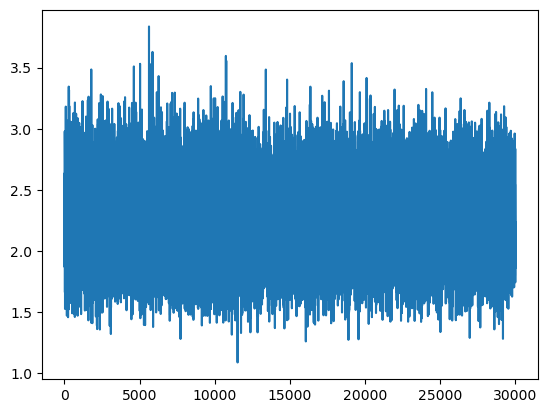

In [84]:
plt.plot(stepi, lossi)
plt.show()

In [85]:
# loss for entire training set

emb = C[Xtr] # (24, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (24, 100)
logits = h @ W2 + b2 # (24, 27)
loss = F.cross_entropy(logits, Ytr)

loss.item()

2.1827707290649414

In [86]:
# loss for entire dev set

emb = C[Xdev] # (24, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (24, 100)
logits = h @ W2 + b2 # (24, 27)
loss = F.cross_entropy(logits, Ydev)

loss.item()

2.1884853839874268

Here, the training loss and dev loss are almost same, this means we are not overfitting, we're underfitting. This model is not powerful enough just to memorize the data. That typically means that our network is very tiny and we expect to make improvements by scaling up this network.

After changing the size of the hidden layer from 100 to 300 we're not getting much improvement. The bottleneck may be the embeddings that are 2 dimensional. May be we are cramming way too many characters in those 2 dimensions and NN is not able to use that space effectively.

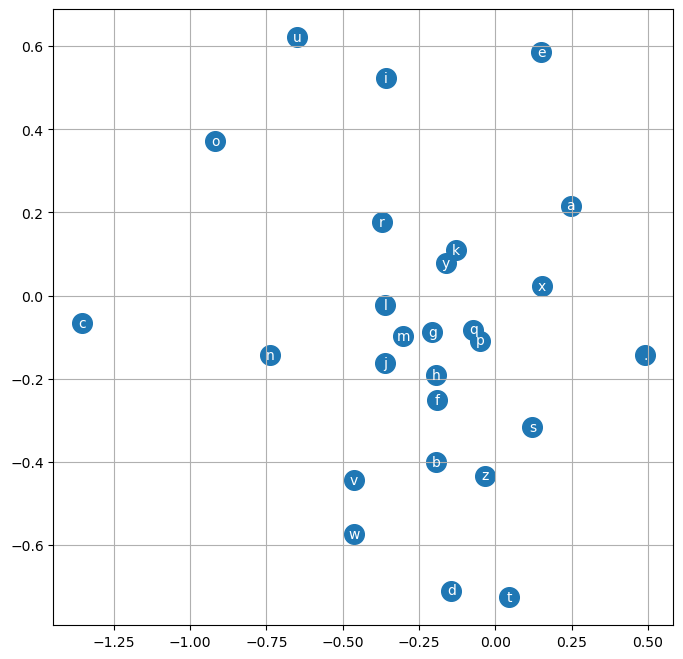

In [89]:
# we can visualize the emb till it is of 2 dim
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')
plt.show()

### Larger Embedding Size

In [97]:
g = torch.Generator().manual_seed(1337101)

C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((3*10, 200), generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [98]:
sum(p.nelement() for p in parameters) # number of parameters

11897

In [99]:
lossi = []
stepi = []

In [109]:
# training on training set

for _ in range(50000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (24, )) # random index of size 24 to select a batch out of X

    # forward pass
    emb = C[Xtr[ix]] # (24, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (24, 100)
    logits = h @ W2 + b2 # (24, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # set grads to zero
    for e in parameters:
        e.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.01 # learning rate
    for w in parameters:
        w.data += -lr * w.grad
    
    #track stats
    lossi.append(loss.log10().item()) # taking log10 for better visuals
    stepi.append(_)

print(loss.item()) # this is the loss for (num of epochs) minibatches

1.8094152212142944


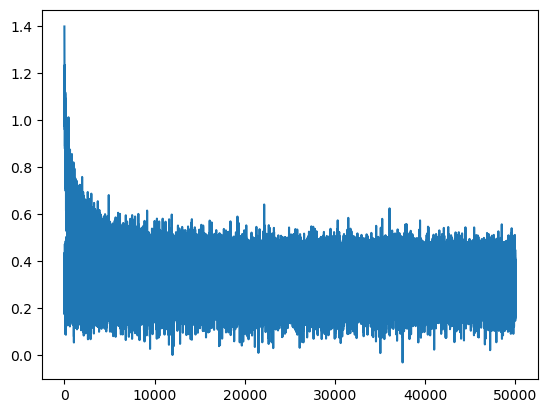

In [110]:
plt.plot(stepi, lossi)
plt.show()

In [112]:
# loss for entire training set

emb = C[Xtr] # (24, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (24, 100)
logits = h @ W2 + b2 # (24, 27)
loss = F.cross_entropy(logits, Ytr)

loss.item()

1.9480324983596802

In [113]:
# loss for entire dev set

emb = C[Xdev] # (24, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (24, 100)
logits = h @ W2 + b2 # (24, 27)
loss = F.cross_entropy(logits, Ydev)

loss.item()

1.9684271812438965

In [126]:
g = torch.Generator().manual_seed(1337101)


for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])] # 1 x block_size x C.shape[1]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (24, 100)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

milomiknivakialaelathisreek.
theessaoradhakireyalleen.
monik.
lajina.
yarshayathi.
yanaathan.
aby.
jokshinila.
waita.
anatha.
aljayan.
thush.
thaanvashwishinalish.
keshad.
hrasadrivarini.
asshamuhant.
niha.
eripeeraj.
adha.
hemitratimojansh.
